In [28]:

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy.stats import lognorm
import os

cats = {
    "EDIP-Gold": "Gold [kg]",
    "EDIP-Copper": "Copper [kg]",
    "ADP-Minerals- Total": "Depletion of Minerals [kg Sb-eq]",
    "EI-Minerals- Total": "Economic Importance [kg Sb-eq]",
    "EI-Minerals-Precious Metals": "Precious Metals",
    "GPR-Minerals- Total": "Geo-Politic Supply Risk [1]",
    "CML-climate change (GWP 100a)": "Green House Emissions",
    "CED - total": "Primary Energy [MJ-eq]",
    "EcoIndicator 99 (E - E) - total":"Total Impacts",
    "ReCiPe Endpoint (E - A) - total (total)": "Total Impacts",
}


sns.set_theme()
sns.set(context="paper", style="whitegrid", font="Times New Roman")
cm = 1/2.54
FONTSIZE = 8

def get_label(shape,scale):
    sigma = "\u03C3"
    mu ="\u03BC"
    geomUnc= np.exp(shape)
    scale_val = "{:.2E}".format(scale)
    geomUnc = "{:.4}".format(geomUnc)
    label = f"{mu} = {scale_val}, " + f"{sigma} = {geomUnc}"
    return label

C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_30704\2925008741.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,2,figsize=(22*cm,7*cm))


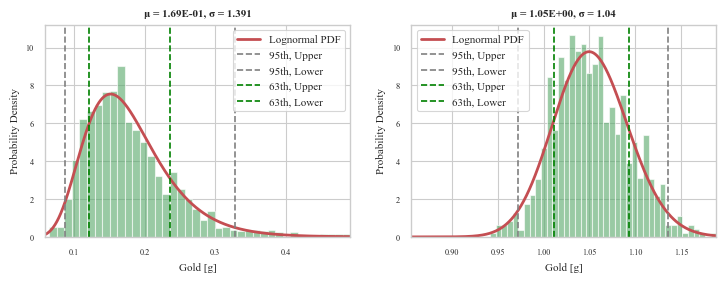

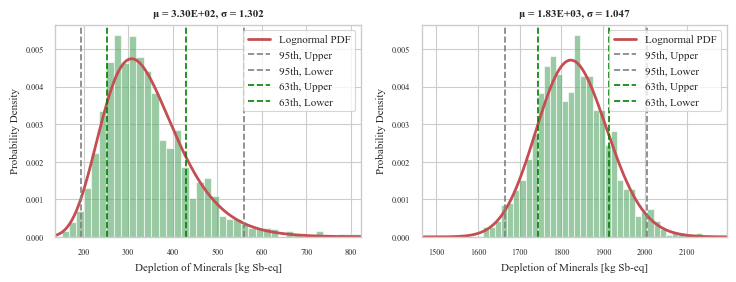

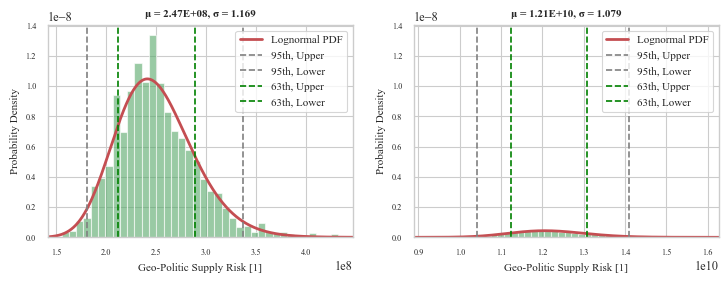

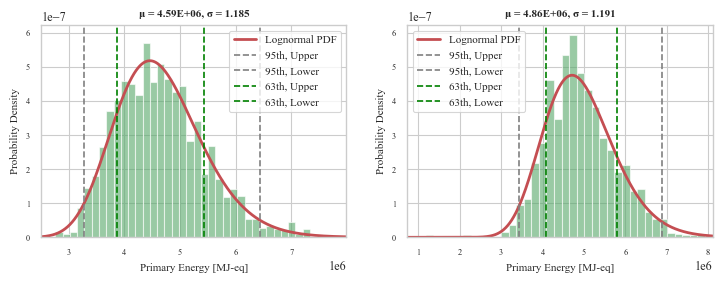

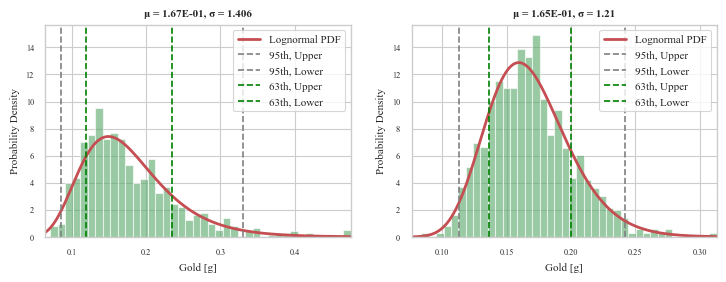

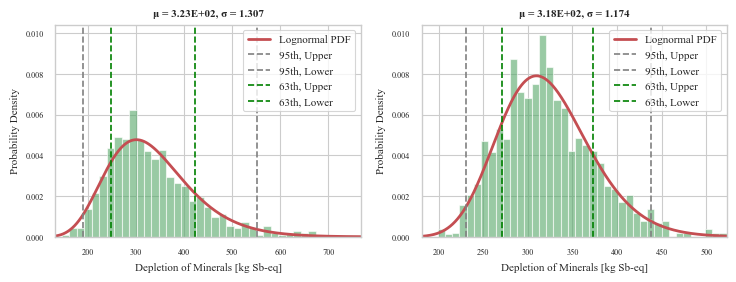

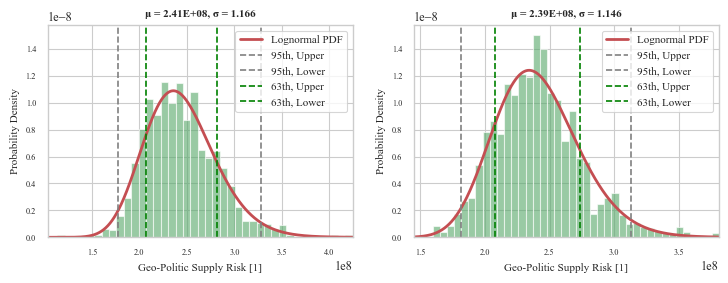

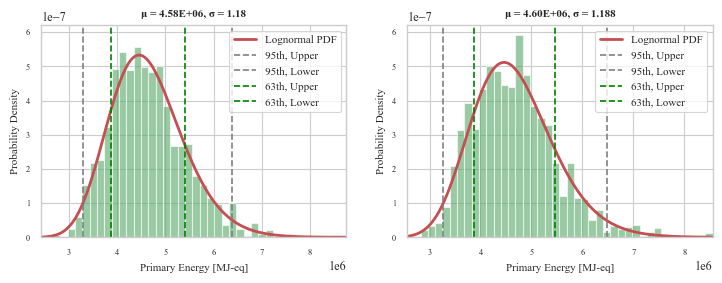

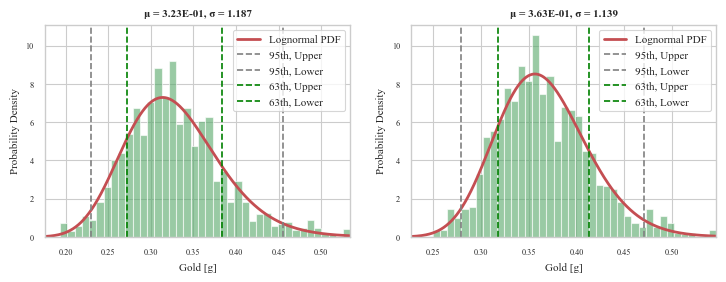

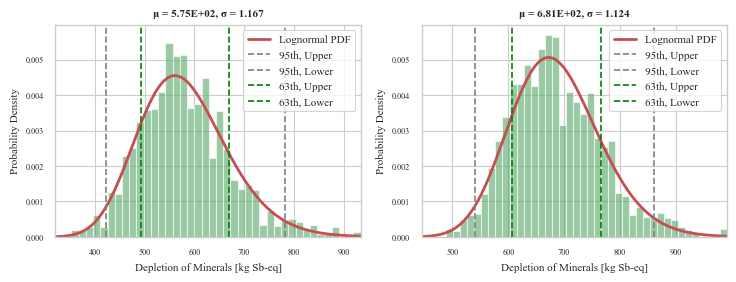

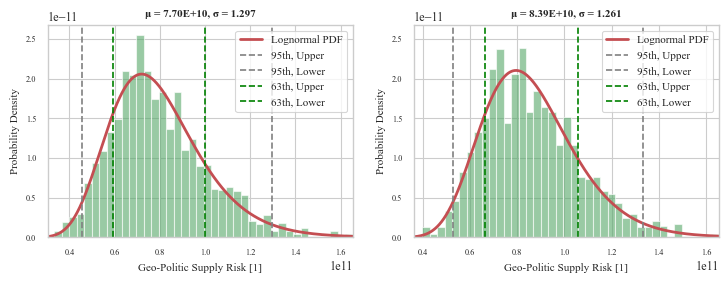

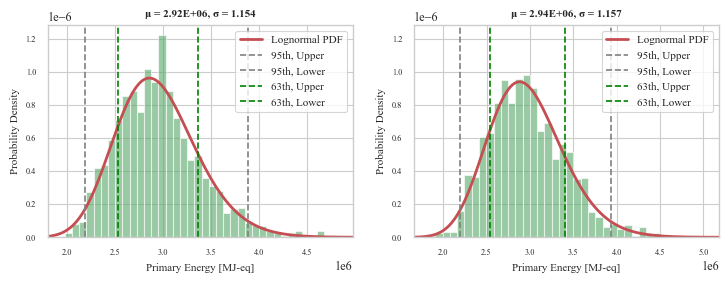

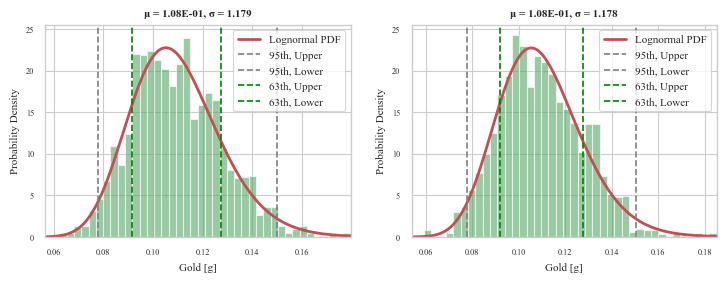

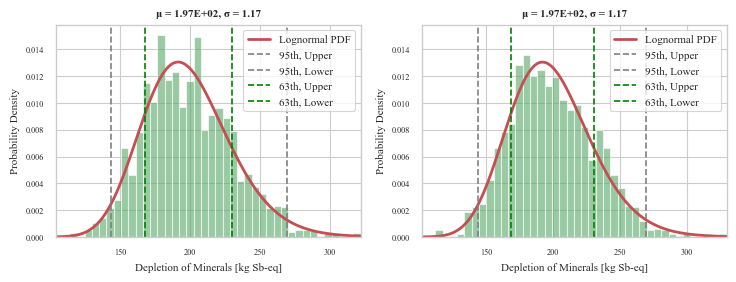

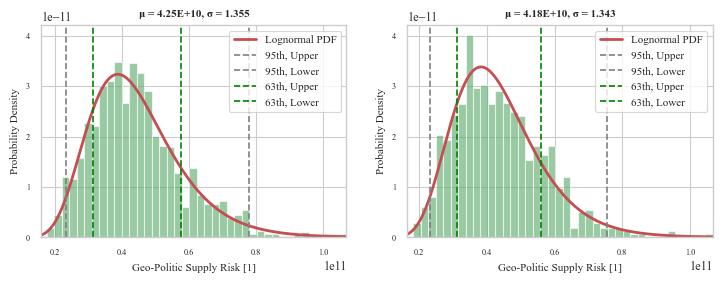

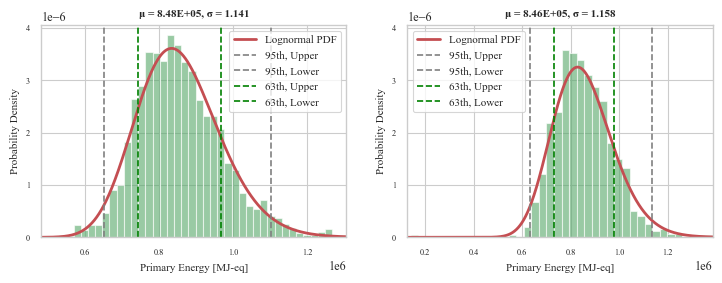

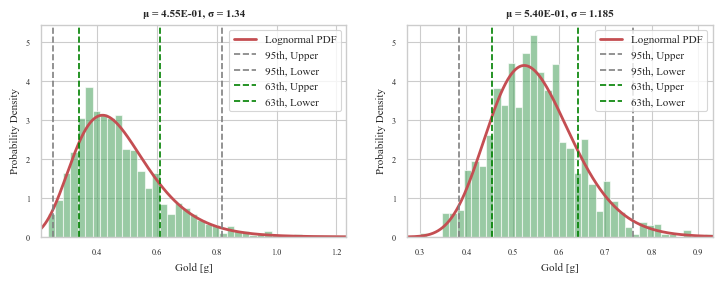

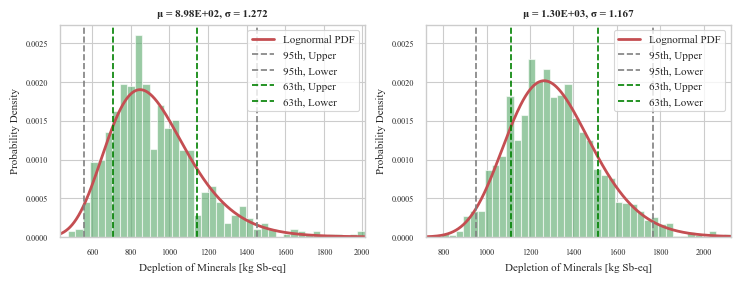

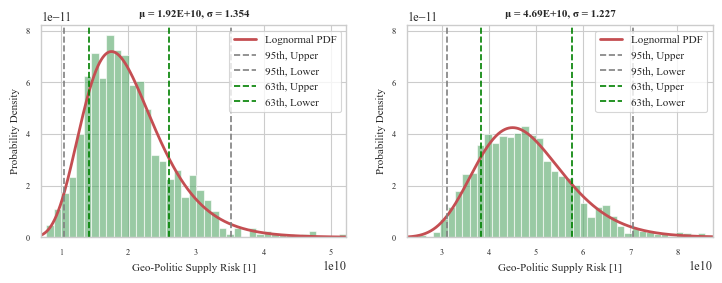

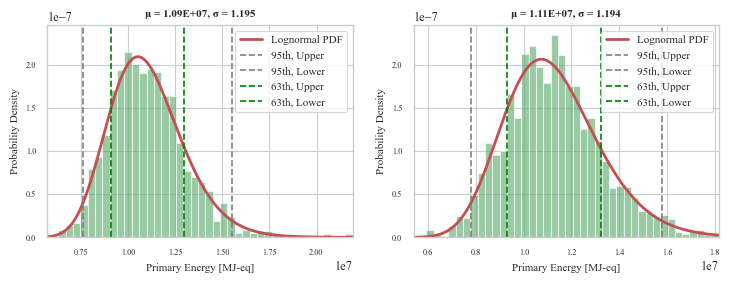

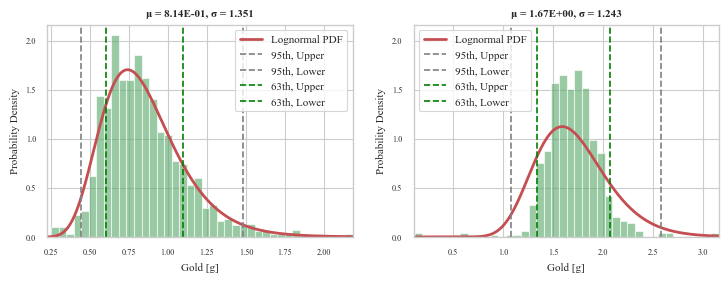

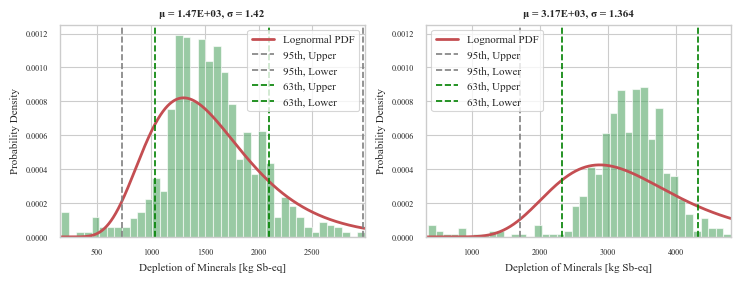

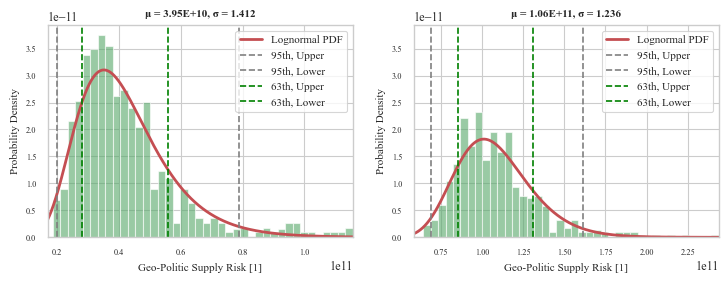

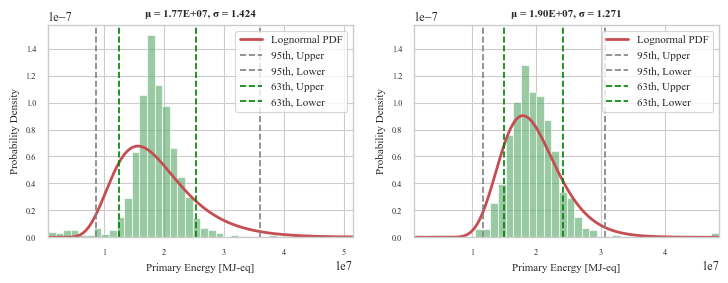

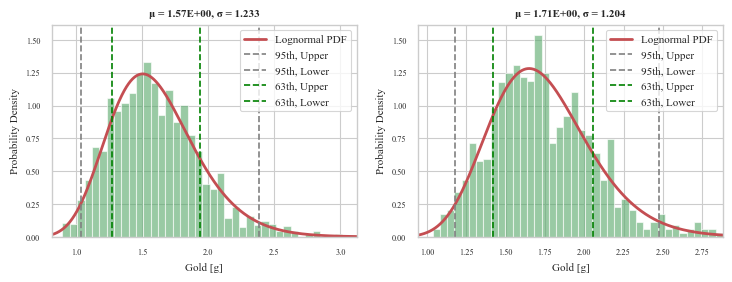

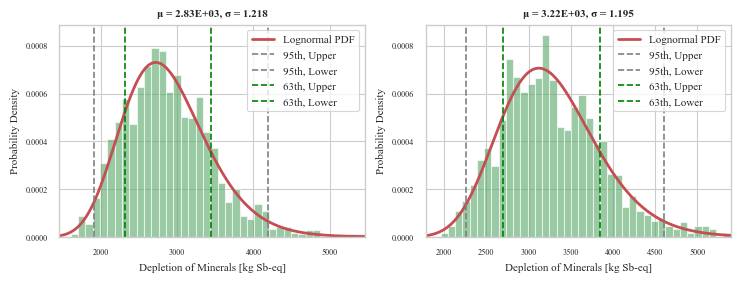

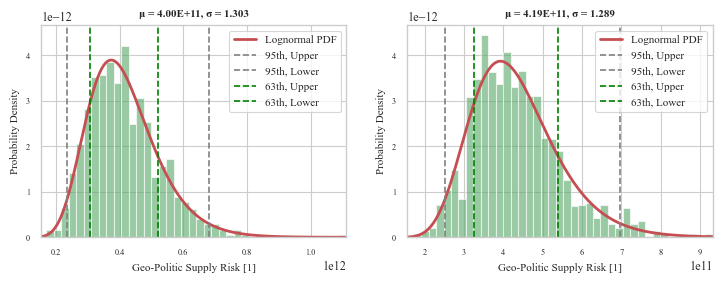

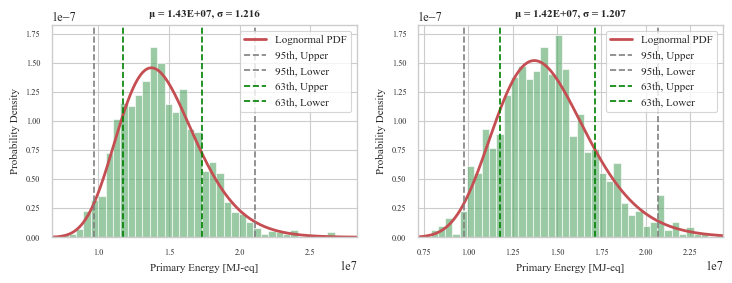

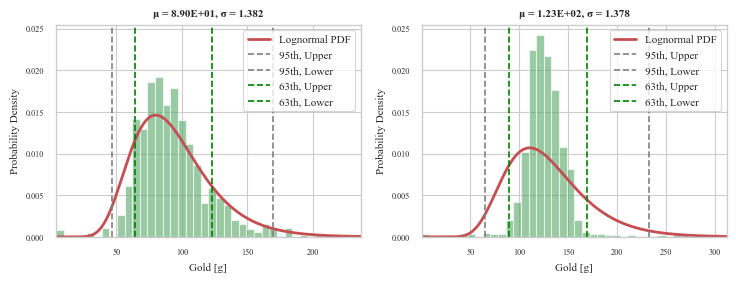

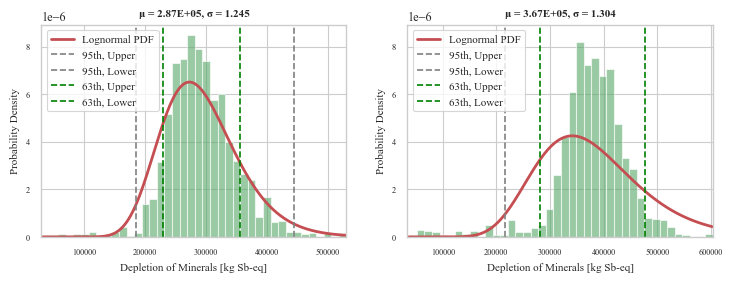

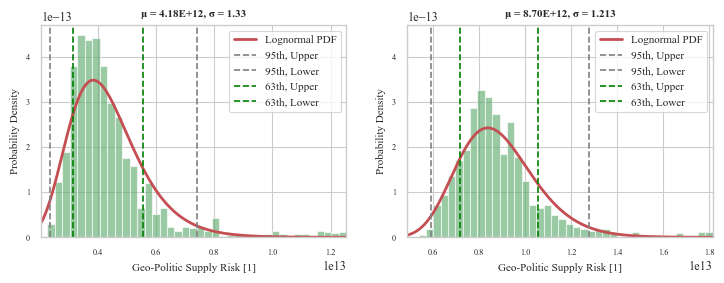

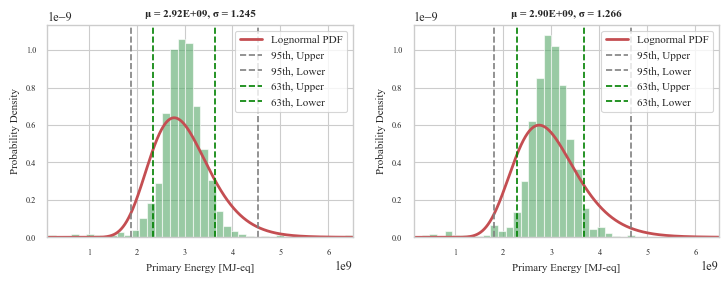

In [35]:
cats = {
    "EDIP-Gold": "Gold [g]",
    #"EDIP-Copper": "Copper [kg]",
    "ADP-Minerals- Total": "Depletion of Minerals [kg Sb-eq]",
    #"EI-Minerals- Total": "Economic Importance [kg Sb-eq]",
    #"EI-Minerals-Precious Metals": "Precious Metals",
    "GPR-Minerals- Total": "Geo-Politic Supply Risk [1]",
    #"CML-climate change (GWP 100a)": "Green House Emissions",
    "CED - total": "Primary Energy [MJ-eq]",
    #"EcoIndicator 99 (E - E) - total":"Total Impacts",
    #"ReCiPe Endpoint (E - A) - total (total)": "Total Impacts",
}

ps_names = [
"3204-CPU, mounted mainboard",
"3208-Mainboard",
"3211-PCB mounted mainboard",
"3219-PCB, for power supply unit",
"4440-Server, 1U, no storage",
"4443-Server, 2U, storage",
"4455-Blade (Ref. Unit)",
#"5101-KDO-IT",
"6001-KDO"
]


for ps_name in ps_names:
    for cat in cats.keys():
        base= "data/MC_TEMPRO_DB220425_{}_{}.csv".format("Base", ps_name)
        corr = "data/MC_TEMPRO_DB220425_{}_{}.csv".format("Corr", ps_name)
        df_mc_base=pd.read_csv(base)
        df_mc_corr=pd.read_csv(corr)
        
        if cat == "EDIP-Gold":
            factor = 1*1000

        data_base = df_mc_base[cat]*factor
        data_corr = df_mc_corr[cat]*factor
        
        y_lims=[]
        data_list = [data_base, data_corr]
        fig, axs = plt.subplots(1,2,figsize=(22*cm,7*cm))
        for i in range(2):
            data=data_list[i]
            data = [x for x in data if x>0]
            for _ in range(10):
                shape, loc, scale = stats.lognorm.fit(data, floc=0)
                data = [x for x in data if x < scale*np.exp(shape)**4]
                data = [x for x in data if x < scale*3]

            shape, loc, scale = stats.lognorm.fit(data, floc=0)
            max_val = max(data)
            min_val = min(data)
            label_title = get_label(shape, scale)
            ax = axs[i]
            ax.hist(data, bins=40, density=True, alpha=0.6, color="g")
            ax.set_xlabel(cats[cat], fontsize=FONTSIZE)
            ax.set_ylabel('Probability Density', fontsize=FONTSIZE)
            ax.set_title(label_title, fontsize=FONTSIZE, fontweight="bold")
            ax.grid(True)
            # Overlay the probability density function (pdf) of the lognormal distribution
            x = np.linspace(0, max_val*1.1, 10000)
            pdf = lognorm.pdf(x, shape, scale=scale)
            ax.plot(x, pdf, 'r-', lw=2, label='Lognormal PDF')
            for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                label.set_fontsize(FONTSIZE*0.75)
            sigma = np.exp(shape)
            ax.axvline(x=scale/sigma/sigma, color='grey',
                    label='95th, Upper', linestyle="--")
            ax.axvline(x=scale*sigma*sigma, color='grey',
                    label='95th, Lower', linestyle="--")
            ax.axvline(x=scale/sigma, color='green',
                    label='63th, Upper', linestyle="--")
            ax.axvline(x=scale*sigma, color='green',
                    label='63th, Lower', linestyle="--")
            ax.set_xlim(min_val/1.1, max_val)
            ax.legend(fontsize=FONTSIZE)
            lim_y = ax.get_ylim()[1]
            y_lims.append(lim_y)

        max_y_lim= max(y_lims)
        for i in range(2):
            ax=axs[i]
            ax.set_ylim(bottom=0, top=max_y_lim)

        folder_path = os.path.join(os.getcwd(),"DirectComparison",ps_name)
        if not os.path.exists(folder_path):
            os.mkdir(folder_path)

        fig.savefig(f"{folder_path}/{ps_name}_{cat}.png", dpi=900, bbox_inches='tight')
        plt.close()
    
